In [41]:
## Data Preprocessing
!pip install statsmodels
import os
import math
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid")


In [42]:
### Notebook Constants
DATA_PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'salary']  # From archive description, fnlwgt will be ignored
req = requests.get(DATA_PATH)

csvreader = csv.reader(req.text, delimiter=",")


In [43]:
def dataToDict(dataText, rowdelimiter="\n", coldelimiter=", "):
    """
    Splits the rows for the data points by the rowdelimiter.
    Splits the column, row-wise 
    """
    rows = list(filter(lambda x: x != '', dataText.split(rowdelimiter)))
    rows = dataText.split(rowdelimiter)[:-2] # Final two rows are blank
    return {i: data.split(coldelimiter) for i, data in enumerate(rows)}


In [44]:
customer_data = dataToDict(req.text)
customer_df = pd.DataFrame.from_dict(customer_data, orient='index', columns=COLUMNS)
customer_df = customer_df.drop("fnlwgt", axis=1)
for col in ["age", "education-num", "capital-gain", "capital-loss",
            "hours-per-week"]:  # Cast numerical columns to numerical data type
    customer_df[col] = pd.to_numeric(customer_df[col])

# Clean '?' Values
print(f"before\n {customer_df.isin(['?']).sum().sum()} values")
customer_df = customer_df.replace("?", "none")
print(f"after\n {customer_df.isin(['?']).sum().sum()} values")


before
 4262 values
after
 0 values


In [45]:
def print_unique_counts(df, column_name):
    if column_name in df.columns:
        value_counts = df[column_name].value_counts()
        print(f"Unique values and their counts for column '{column_name}':")
        print(value_counts)
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

In [46]:
# Identify columns that contain the value
columns_with_value = [col for col in customer_df.columns if (customer_df[col] == "none").any()]
# Print the names of these columns
print("Columns containing the none value:", columns_with_value)
#print(f"\n {customer_df.isin(['none']).sum()}")
#native-country     583
#occupation        1843
#workclass         1836
#print(customer_df.head())



Columns containing the none value: ['workclass', 'occupation', 'native-country']


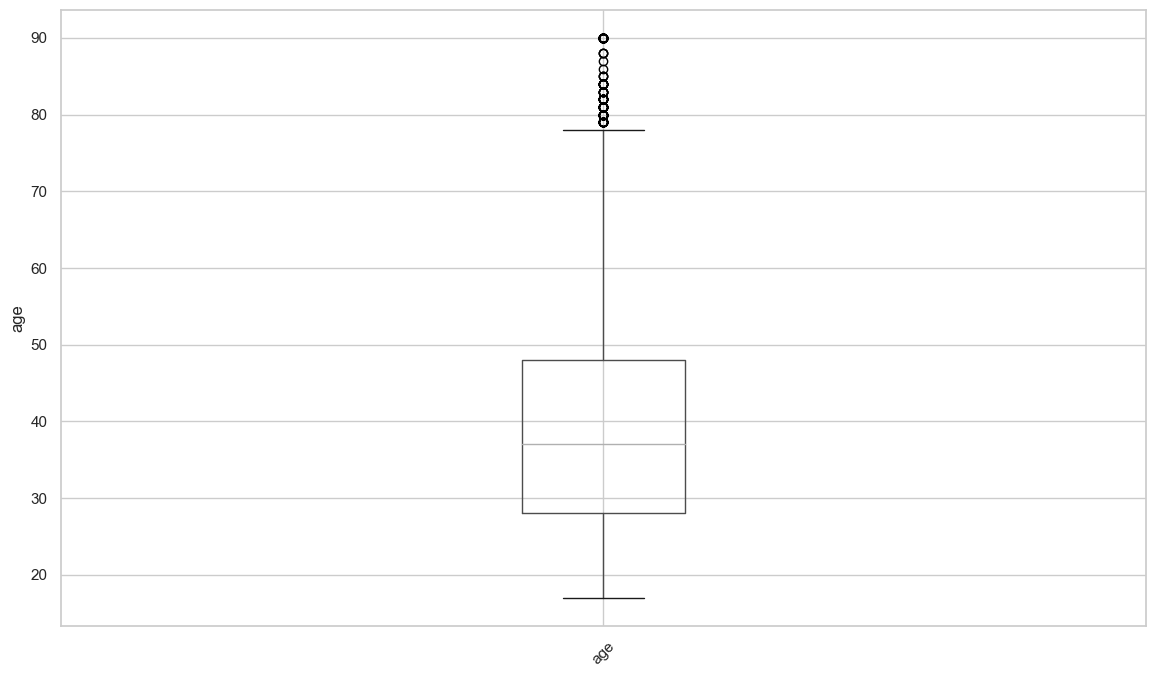

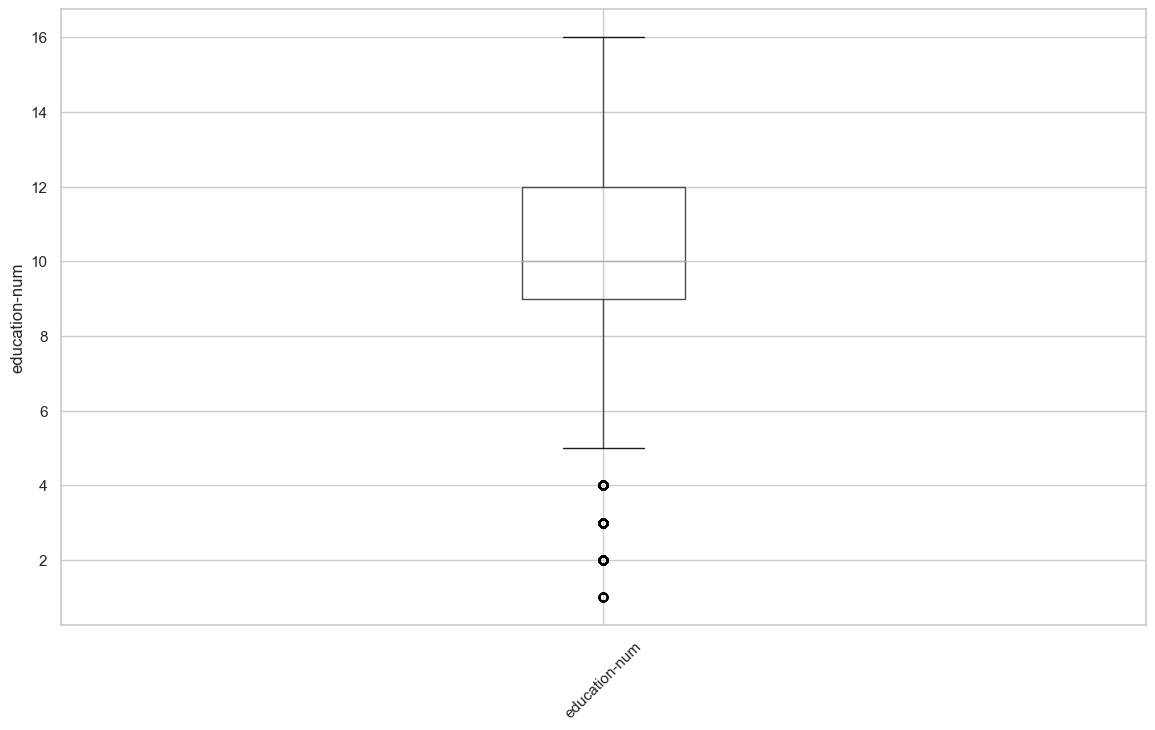

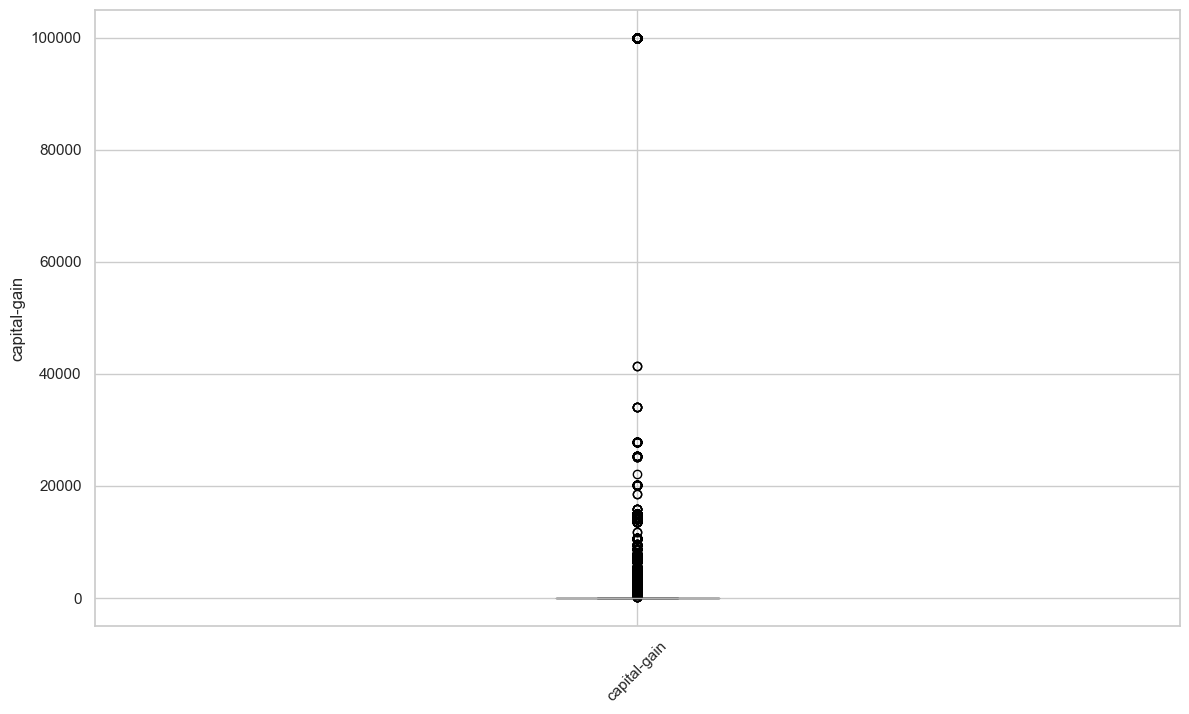

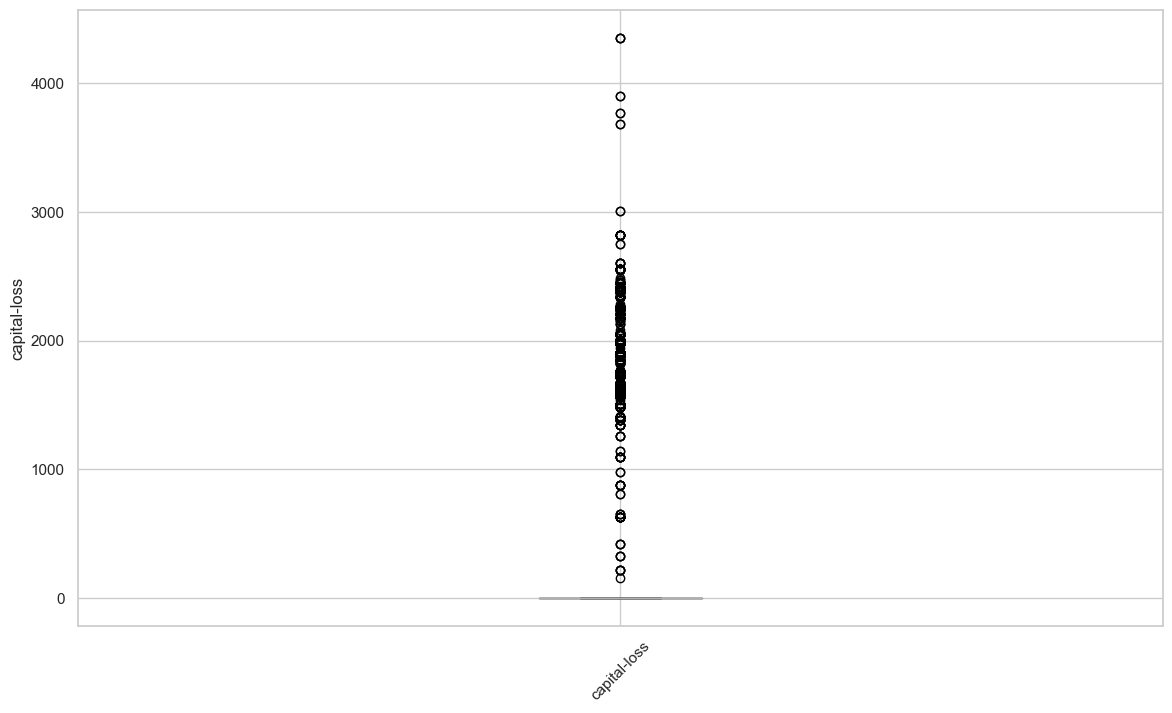

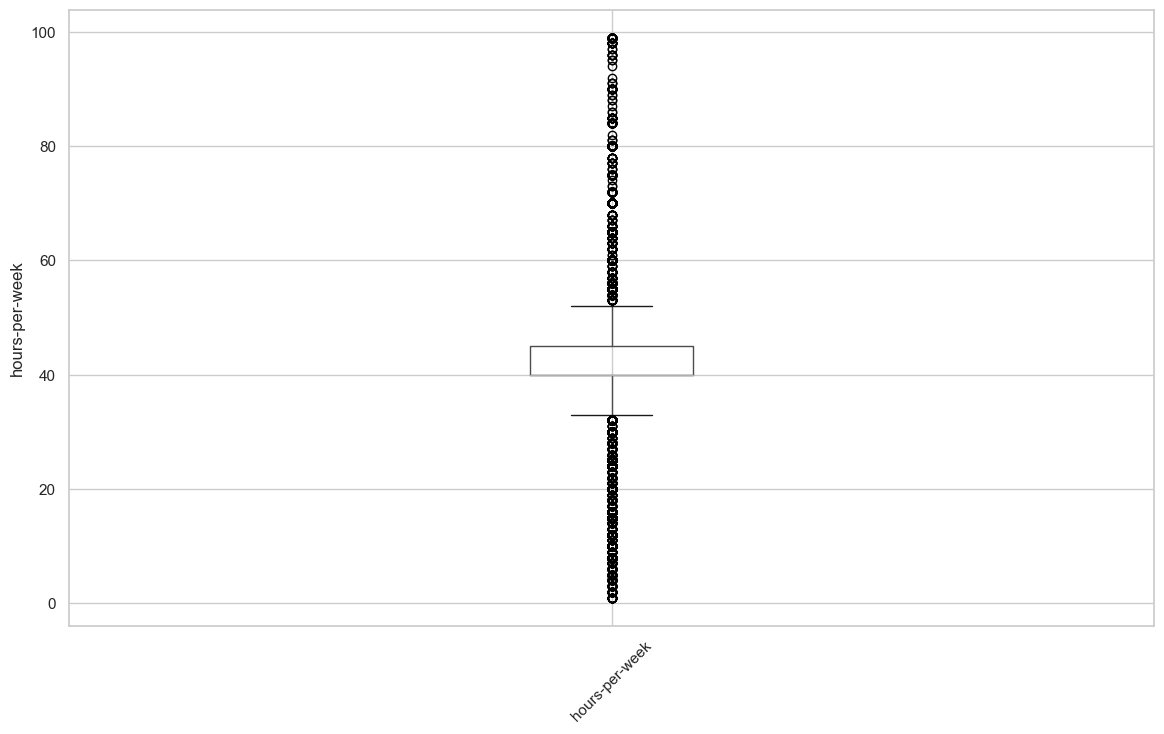

{'age': {'lBound': -2.0, 'uBound': 78.0, 'outlier_count': 143}, 'education-num': {'lBound': 4.5, 'uBound': 16.5, 'outlier_count': 1198}, 'capital-gain': {'lBound': 0.0, 'uBound': 0.0, 'outlier_count': 2712}, 'capital-loss': {'lBound': 0.0, 'uBound': 0.0, 'outlier_count': 1519}, 'hours-per-week': {'lBound': 32.5, 'uBound': 52.5, 'outlier_count': 9008}}


In [47]:
CONTINUOS_COLUMNS = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

outlier_counts = {}

for column in CONTINUOS_COLUMNS:
    # Compute Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = customer_df[column].quantile(0.25)
    Q3 = customer_df[column].quantile(0.75)
    # Compute IQR
    IQR = Q3 - Q1
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = customer_df[(customer_df[column] < lower_bound) | (customer_df[column] > upper_bound)]
    outlier_count = outliers.shape[0]
    
    temp_dict = {}
    temp_dict["lBound"] = lower_bound
    temp_dict["uBound"] = upper_bound
    temp_dict["outlier_count"] = outlier_count
    # Store the count in the dictionary
    outlier_counts[column] = temp_dict
    
    plt.figure(figsize=(14, 8))
    customer_df.boxplot(column=column)
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()


print(outlier_counts)

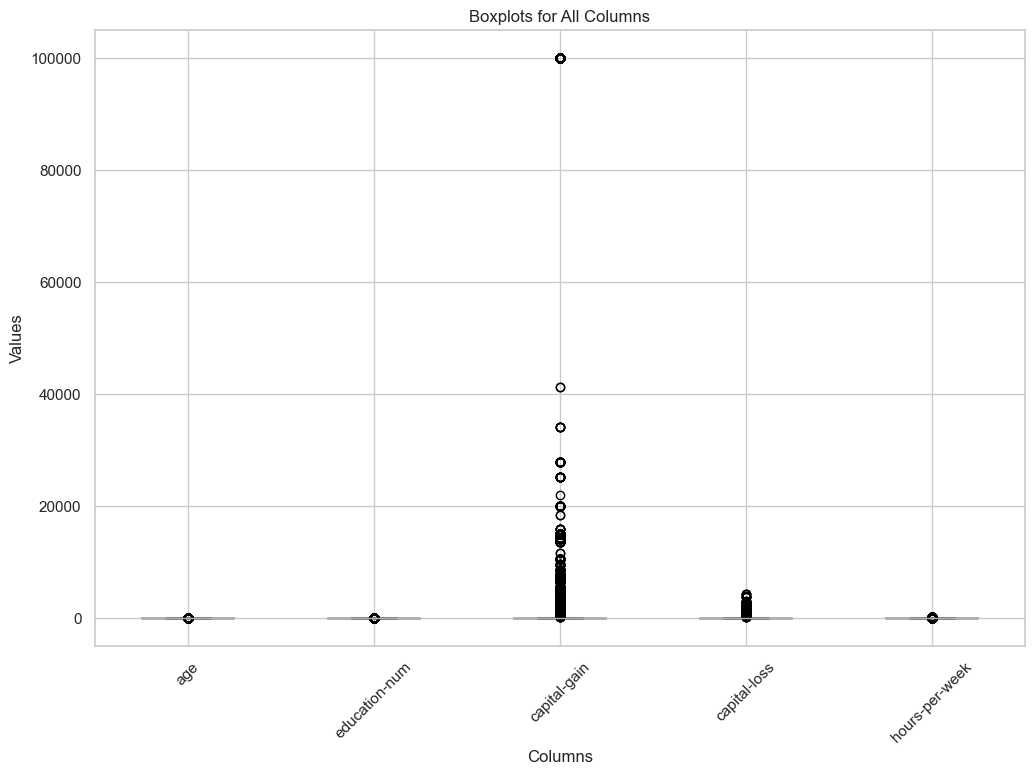

In [48]:
plt.figure(figsize=(12, 8))
customer_df.boxplot()

plt.title('Boxplots for All Columns')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

unfilter---> age :
 36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64
FilteredData---> age :
 36    898
31    888
34    886
23    877
35    876
     ... 
74     51
76     46
75     45
77     29
78     23
Name: age, Length: 62, dtype: int64


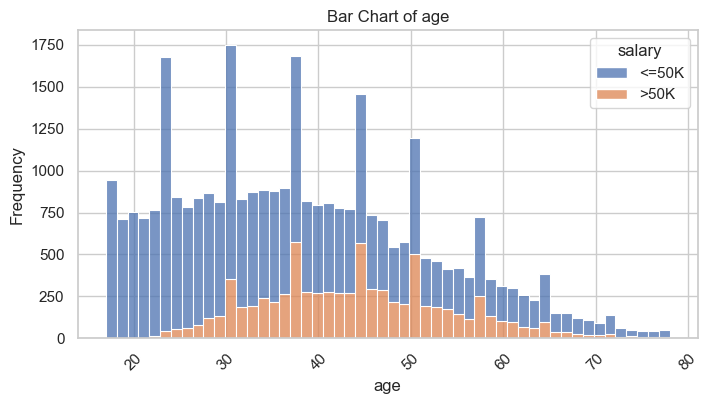

unfilter---> workclass :
 Private             22696
Self-emp-not-inc     2541
Local-gov            2093
none                 1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
FilteredData---> workclass :
 Private             22696
Self-emp-not-inc     2541
Local-gov            2093
none                 1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


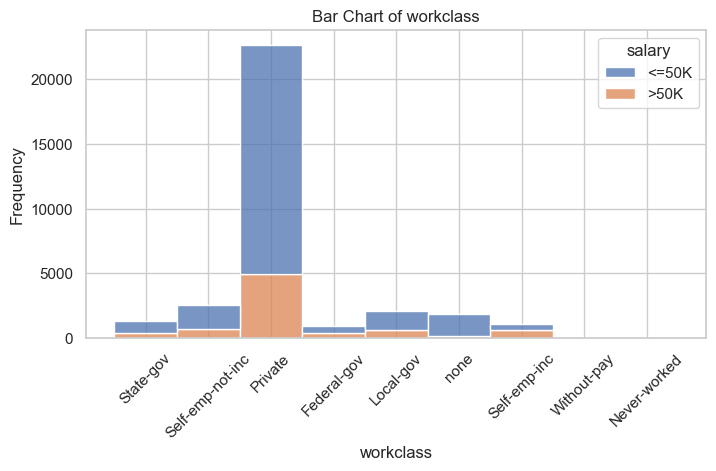

unfilter---> education :
 HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
FilteredData---> education :
 HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
Prof-school       576
9th               514
12th              433
Doctorate         413
Name: education, dtype: int64


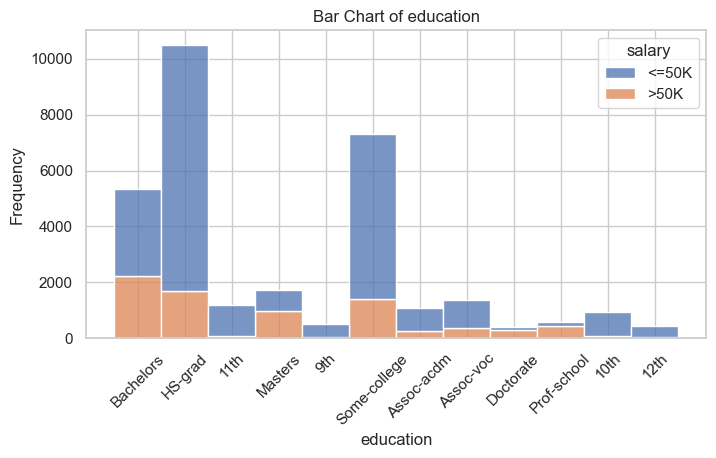

unfilter---> education-num :
 9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education-num, dtype: int64
FilteredData---> education-num :
 9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
15      576
5       514
8       433
16      413
Name: education-num, dtype: int64


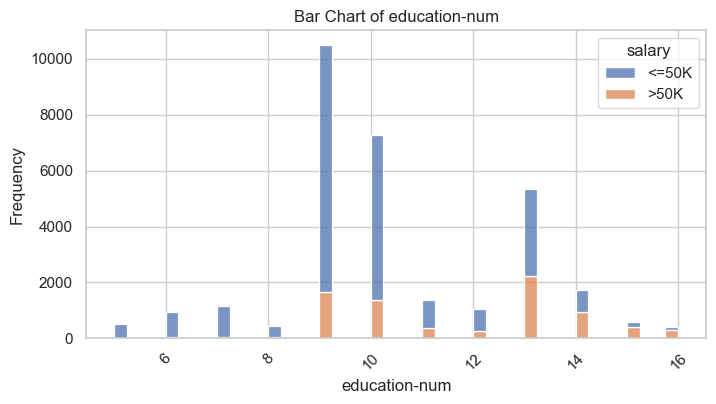

unfilter---> marital-status :
 Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64
FilteredData---> marital-status :
 Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64


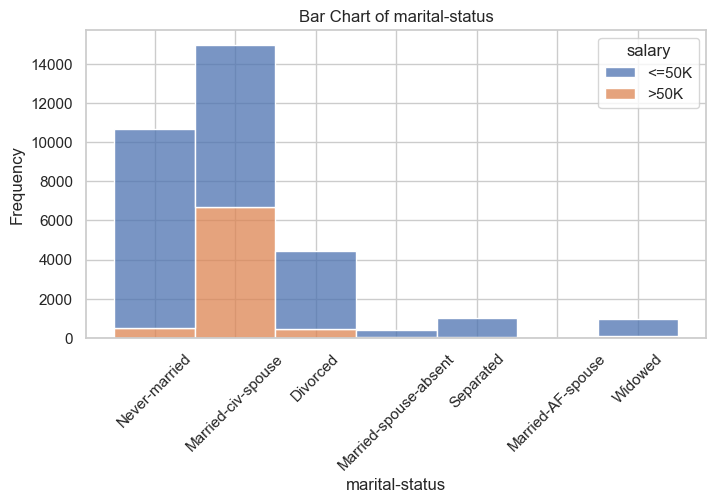

unfilter---> occupation :
 Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
none                 1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64
FilteredData---> occupation :
 Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
none                 1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


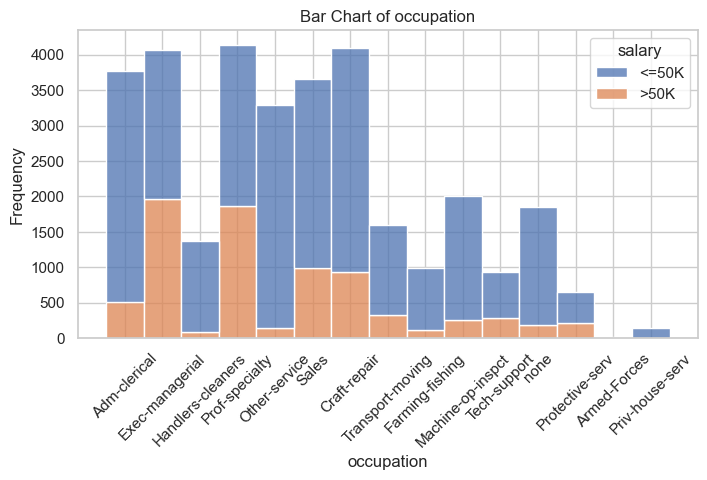

unfilter---> relationship :
 Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64
FilteredData---> relationship :
 Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


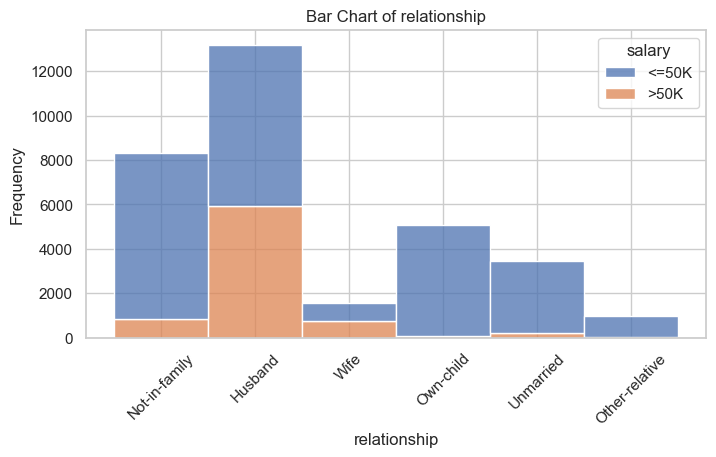

unfilter---> race :
 White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64
FilteredData---> race :
 White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


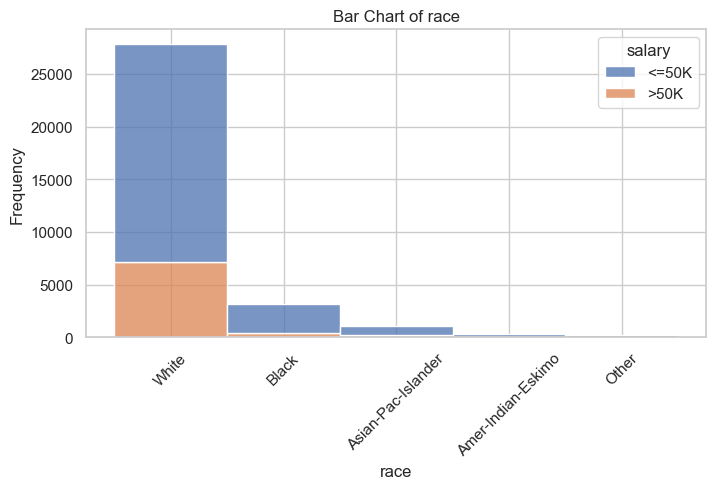

unfilter---> sex :
 Male      21790
Female    10771
Name: sex, dtype: int64
FilteredData---> sex :
 Male      21790
Female    10771
Name: sex, dtype: int64


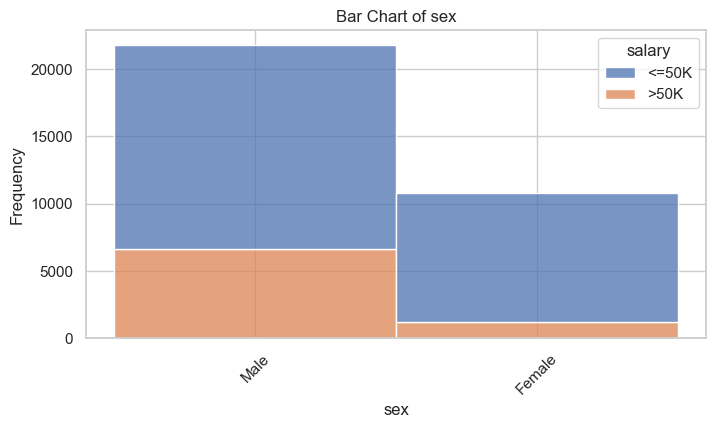

unfilter---> capital-gain :
 0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
1111         1
2538         1
22040        1
4931         1
5060         1
Name: capital-gain, Length: 119, dtype: int64
FilteredData---> capital-gain :
 0    29849
Name: capital-gain, dtype: int64


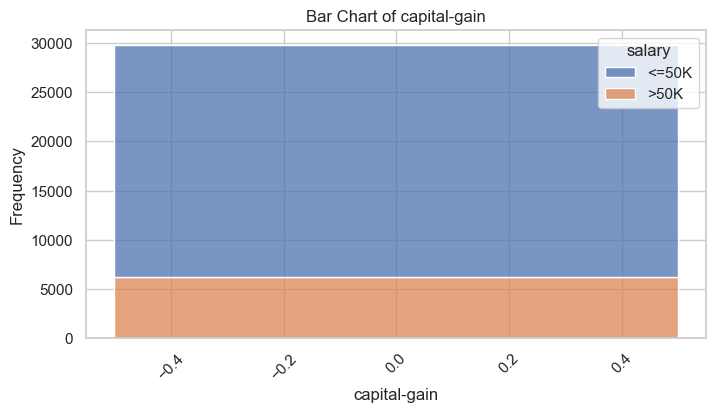

unfilter---> capital-loss :
 0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
2080        1
1539        1
1844        1
2489        1
1411        1
Name: capital-loss, Length: 92, dtype: int64
FilteredData---> capital-loss :
 0    31042
Name: capital-loss, dtype: int64


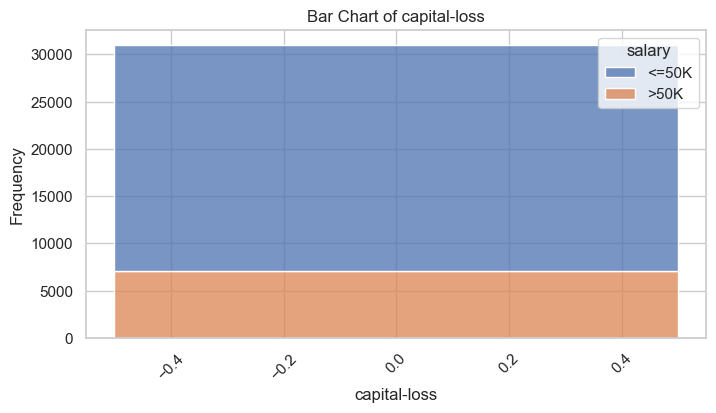

unfilter---> hours-per-week :
 40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
92        1
87        1
74        1
94        1
Name: hours-per-week, Length: 94, dtype: int64
FilteredData---> hours-per-week :
 40    15217
50     2819
45     1824
35     1297
48      517
38      476
36      220
42      219
44      212
43      151
37      149
52      138
46       82
47       49
33       39
39       38
41       36
49       29
34       28
51       13
Name: hours-per-week, dtype: int64


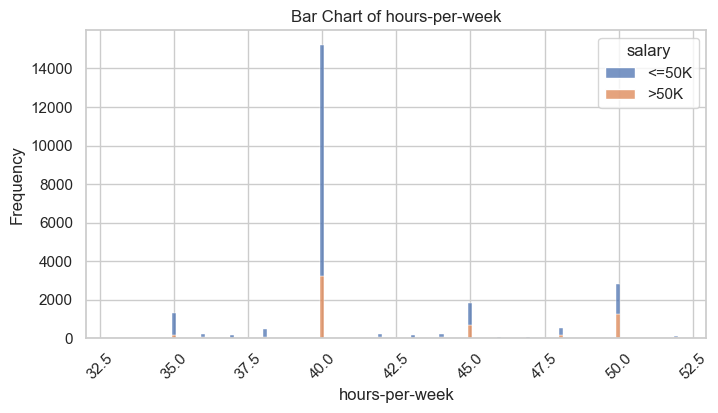

"\nsns.histplot(customer_df, x='age', hue='salary', multiple='stack')\nplt.title('Age Distribution by Salary Level')\nplt.xlabel('Age')\nplt.ylabel('Count')\n# Adjust layout for better display\n#plt.tight_layout()\nplt.show()\n"

In [49]:
"""
COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'salary']
"""
def plot_column_filter_by_class(data, column):
    newdata = data
    filtercolumn = column
    if column == "education":
        filtercolumn = "education-num"
        
    if (filtercolumn in CONTINUOS_COLUMNS):
        Q1 = data[filtercolumn].quantile(0.25)
        Q3 = data[filtercolumn].quantile(0.75)
        # Compute IQR
        IQR = Q3 - Q1
        # Determine the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Find outliers
        newdata = data[(data[filtercolumn] >= lower_bound) & (data[filtercolumn] <= upper_bound)]

    print(f"unfilter---> {column} :\n {data[column].value_counts()}")
    print(f"FilteredData---> {column} :\n {newdata[column].value_counts()}")
    
    plt.figure(figsize=(8, 4))
    #sns.countplot(data=customer_df, x=column, palette='viridis', edgecolor='black')
    sns.histplot(newdata, x=column, hue='salary', multiple='stack')
    plt.title(f'Bar Chart of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.show()

#plot_column_filter_by_class(customer_df, "education-num")
#for column in customer_df.select_dtypes(include='object').columns:
for column in customer_df.columns:
    if column in ["native-country","salary"]:
        continue
    plot_column_filter_by_class(customer_df, column)

#print_unique_counts(customer_df, 'age')
#customer_df.hist(figsize=(10, 6), bins=10, edgecolor='black')
#plt.figure(figsize=(10, 6))
"""
sns.histplot(customer_df, x='age', hue='salary', multiple='stack')
plt.title('Age Distribution by Salary Level')
plt.xlabel('Age')
plt.ylabel('Count')
# Adjust layout for better display
#plt.tight_layout()
plt.show()
"""


(10501, 14)
unfilter---> age :
 35    320
33    313
36    311
34    308
37    301
     ... 
83      4
82      4
84      3
85      2
87      1
Name: age, Length: 71, dtype: int64
FilteredData---> age :
 35    320
33    313
36    311
34    308
37    301
     ... 
75     13
76     12
17      8
77      7
78      6
Name: age, Length: 62, dtype: int64


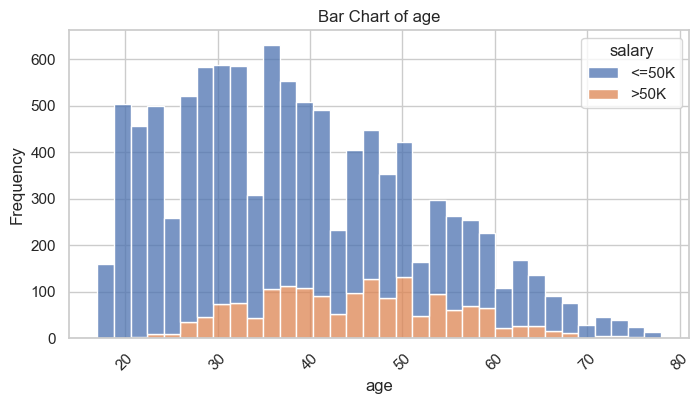

unfilter---> workclass :
 Private             7780
Self-emp-not-inc     866
none                 532
Local-gov            503
Self-emp-inc         279
State-gov            268
Federal-gov          263
Without-pay            9
Never-worked           1
Name: workclass, dtype: int64
FilteredData---> workclass :
 Private             7780
Self-emp-not-inc     866
none                 532
Local-gov            503
Self-emp-inc         279
State-gov            268
Federal-gov          263
Without-pay            9
Never-worked           1
Name: workclass, dtype: int64


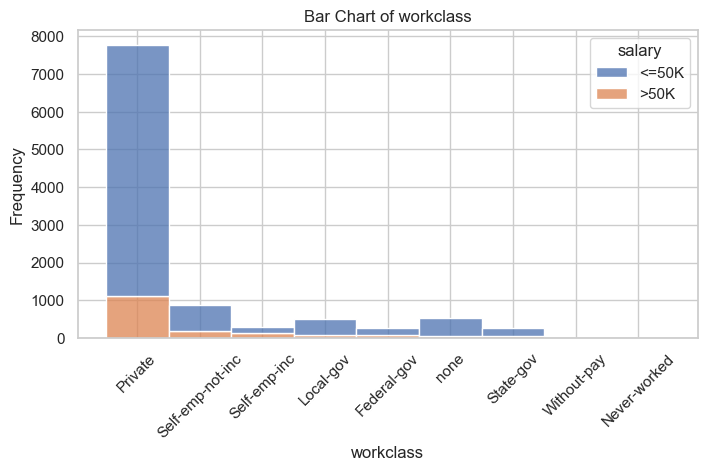

unfilter---> marital-status :
 Married-civ-spouse       4845
Never-married            3089
Divorced                 1613
Widowed                   414
Separated                 406
Married-spouse-absent     121
Married-AF-spouse          13
Name: marital-status, dtype: int64
FilteredData---> marital-status :
 Married-civ-spouse       4845
Never-married            3089
Divorced                 1613
Widowed                   414
Separated                 406
Married-spouse-absent     121
Married-AF-spouse          13
Name: marital-status, dtype: int64


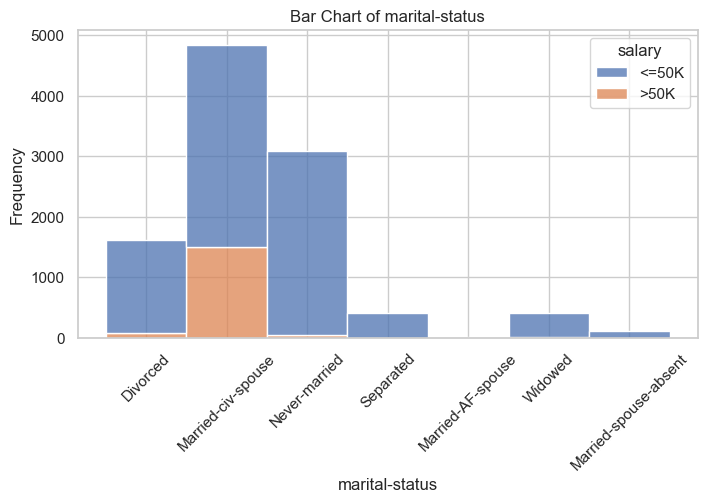

unfilter---> occupation :
 Craft-repair         1922
Adm-clerical         1365
Other-service        1281
Sales                1069
Machine-op-inspct    1023
Transport-moving      825
Exec-managerial       807
Handlers-cleaners     611
none                  533
Farming-fishing       404
Prof-specialty        233
Protective-serv       215
Tech-support          159
Priv-house-serv        50
Armed-Forces            4
Name: occupation, dtype: int64
FilteredData---> occupation :
 Craft-repair         1922
Adm-clerical         1365
Other-service        1281
Sales                1069
Machine-op-inspct    1023
Transport-moving      825
Exec-managerial       807
Handlers-cleaners     611
none                  533
Farming-fishing       404
Prof-specialty        233
Protective-serv       215
Tech-support          159
Priv-house-serv        50
Armed-Forces            4
Name: occupation, dtype: int64


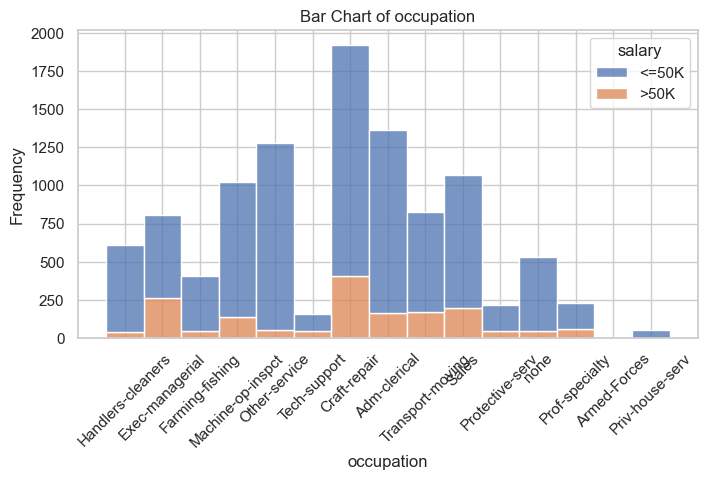

unfilter---> relationship :
 Husband           4279
Not-in-family     2517
Own-child         1504
Unmarried         1312
Wife               498
Other-relative     391
Name: relationship, dtype: int64
FilteredData---> relationship :
 Husband           4279
Not-in-family     2517
Own-child         1504
Unmarried         1312
Wife               498
Other-relative     391
Name: relationship, dtype: int64


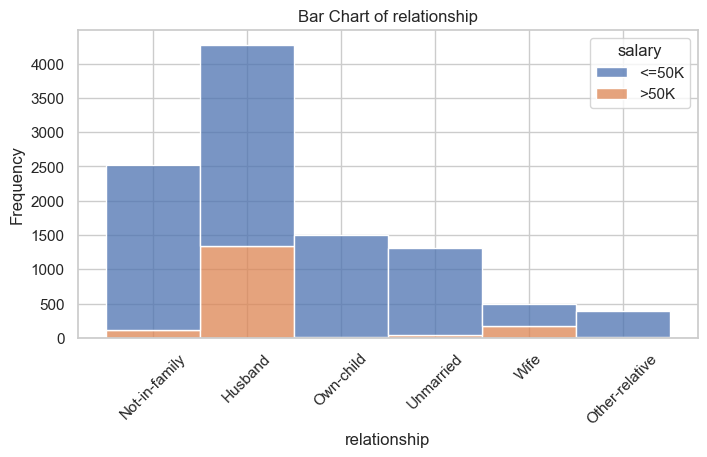

unfilter---> race :
 White                 8904
Black                 1174
Asian-Pac-Islander     226
Amer-Indian-Eskimo     119
Other                   78
Name: race, dtype: int64
FilteredData---> race :
 White                 8904
Black                 1174
Asian-Pac-Islander     226
Amer-Indian-Eskimo     119
Other                   78
Name: race, dtype: int64


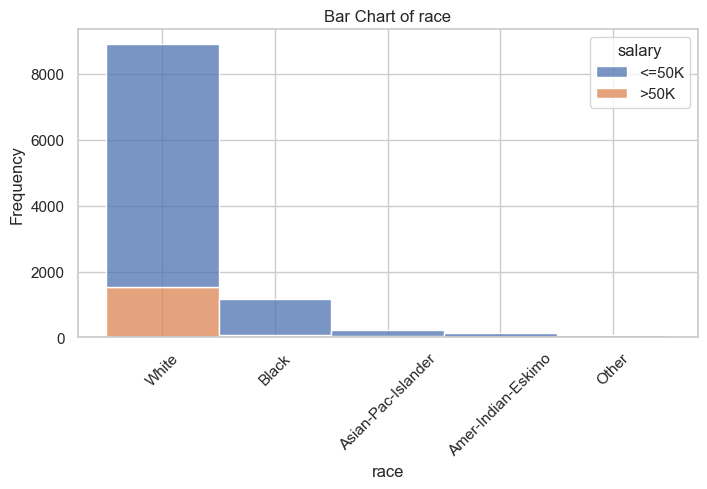

unfilter---> sex :
 Male      7111
Female    3390
Name: sex, dtype: int64
FilteredData---> sex :
 Male      7111
Female    3390
Name: sex, dtype: int64


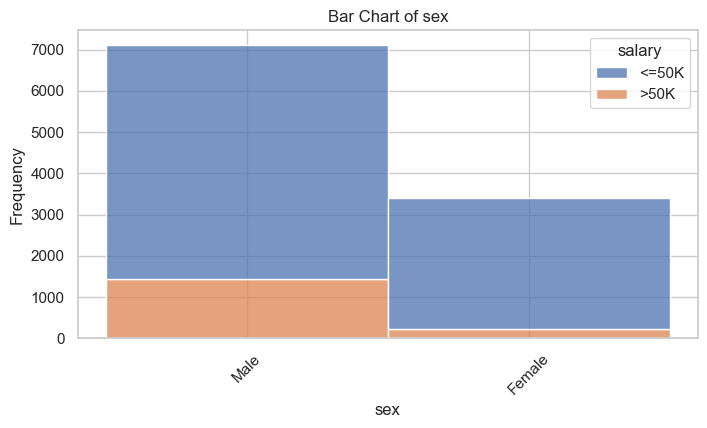

unfilter---> hours-per-week :
 40    5524
50     715
45     499
35     426
60     399
      ... 
97       1
82       1
94       1
89       1
95       1
Name: hours-per-week, Length: 86, dtype: int64
FilteredData---> hours-per-week :
 40    5524
45     499
38     173
44      82
42      69
37      56
43      42
41      15
39       6
Name: hours-per-week, dtype: int64


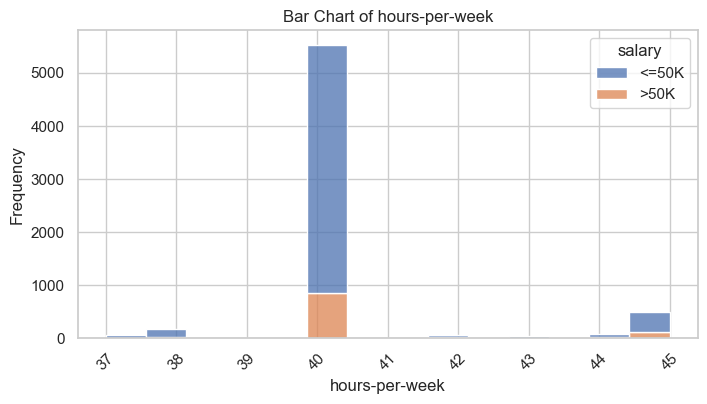

In [40]:
filtered_hs_grad = customer_df[customer_df["education"] == "HS-grad"]
print(filtered_hs_grad.shape)


for column in customer_df.columns:
    if column in ["education-num", "education", "native-country","salary", "capital-loss", "capital-gain"]:
        continue
    plot_column_filter_by_class(filtered_hs_grad, column)


In [78]:
#fig = px.parallel_categories(customer_df, dimensions=['relationship', 'salary'])
fig = px.parallel_categories(customer_df, dimensions=['relationship', 'marital-status', 'salary'])
#fig = px.parallel_categories(filtered_hs_grad, dimensions=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'salary'])
fig.show()
#fig1 = px.parallel_categories(customer_df, dimensions=['marital-status', 'salary'])
#fig1.show()



C:\Users\bistp\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [77]:
filtered_wh = customer_df[(customer_df['hours-per-week'] >= 32.5) & (customer_df['hours-per-week'] <= 52.5)]

def round_to_nearest_5(x):
    return 5 * round(x / 5)

filtered_wh['rounded_values'] = filtered_wh['hours-per-week'].apply(round_to_nearest_5)

fig = px.parallel_categories(filtered_wh, dimensions=['rounded_values', 'salary'])
#fig = px.parallel_categories(customer_df, dimensions=['relationship', 'marital-status', 'salary'])
#fig = px.parallel_categories(filtered_hs_grad, dimensions=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'salary'])
fig.show()

customer_df_round = customer_df[(customer_df['hours-per-week'] < 32.5)]
customer_df_round['rounded_values'] = customer_df_round['hours-per-week'].apply(round_to_nearest_10)
fig = px.parallel_categories(customer_df_round, dimensions=['rounded_values', 'salary'])
fig.show()



C:\Users\bistp\AppData\Local\Temp\ipykernel_6928\832988330.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bistp\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



C:\Users\bistp\AppData\Local\Temp\ipykernel_6928\832988330.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bistp\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [73]:
filtered_age = customer_df[customer_df['age'] <= 78]

def round_to_nearest_10(x):
    return 10 * round(x / 10)

filtered_age['rounded_values'] = filtered_age['age'].apply(round_to_nearest_10)

fig = px.parallel_categories(filtered_age, dimensions=['rounded_values', 'salary'])
#fig = px.parallel_categories(filtered_hs_grad, dimensions=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'salary'])
fig.show()


C:\Users\bistp\AppData\Local\Temp\ipykernel_6928\4118976581.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bistp\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [74]:
filtered_capital_gain = customer_df[customer_df['capital-gain'] == 0.0]

fig = px.parallel_categories(filtered_capital_gain , dimensions=['capital-gain', 'salary'])
#fig = px.parallel_categories(filtered_hs_grad, dimensions=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'salary'])
fig.show()


C:\Users\bistp\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



C:\Users\bistp\AppData\Local\Temp\ipykernel_6928\1690516052.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(<Figure size 640x480 with 3 Axes>,
 {('Married-civ-spouse', '<=50K'): (0.0,
   0.0,
   0.2995217174886922,
   0.5588308720450137),
  ('Married-civ-spouse', '>50K'): (0.0,
   0.5621531311812262,
   0.2995217174886922,
   0.4378468688187736),
  ('Never-married', '<=50K'): (0.30439976626918,
   0.0,
   0.37223797260155395,
   0.957274202271498),
  ('Never-married', '>50K'): (0.30439976626918,
   0.9605964614077106,
   0.37223797260155395,
   0.03940353859228931),
  ('Separated', '<=50K'): (0.6815157876512218,
   0.0,
   0.06492522777934072,
   0.9700996677740864),
  ('Separated', '>50K'): (0.6815157876512218,
   0.9734219269102989,
   0.06492522777934072,
   0.026578073089700945),
  ('Divorced', '<=50K'): (0.7513190642110503,
   0.0,
   0.16880559222628613,
   0.8995655507283413),
  ('Divorced', '>50K'): (0.7513190642110503,
   0.902887809864554,
   0.16880559222628613,
   0.09711219013544593),
  ('Widowed', '<=50K'): (0.9250027052178242,
   0.0,
   0.04847750340857444,
   0.978879924062

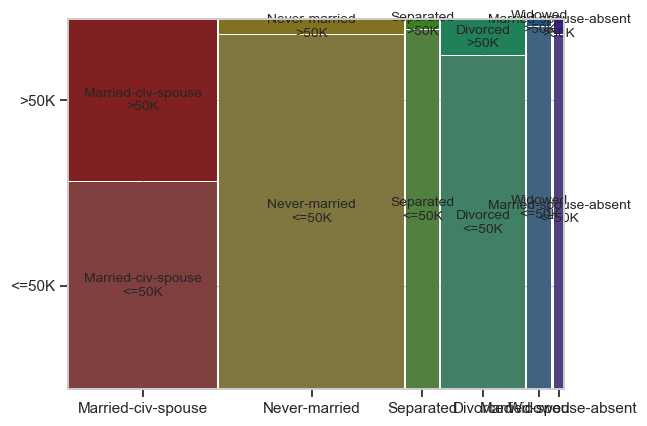

In [63]:
"""
COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'salary']  # From archive description, fnlwgt will be ignored
"""
filtered_nonwhite_nonasian_race = customer_df[(customer_df["race"] != "White") & (customer_df["race"] != "Asian-Pac-Islander")]
filtered_white_asian_race = customer_df[(customer_df["race"] == "White") | (customer_df["race"] == "Asian-Pac-Islander")]
#fig = px.parallel_categories(filtered_nonwhite_nonasian_race, dimensions=['race', 'workclass','salary'])
#fig.show()
#fig1 = px.parallel_categories(filtered_white_asian_race, dimensions=['race', 'salary'])
#fig1.show()
filtered_nonwhite_nonasian_private_race = filtered_nonwhite_nonasian_race[(customer_df["workclass"] != "Private")]
#fig = px.parallel_categories(filtered_nonwhite_nonasian_private_race, dimensions=['race', 'workclass','salary'])
#fig.show()
mosaic(filtered_nonwhite_nonasian_private_race, ["marital-status", "salary"])



(10501, 14)


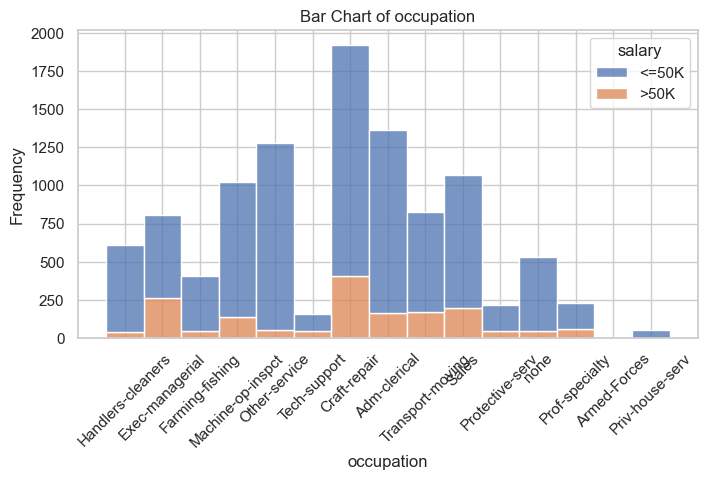

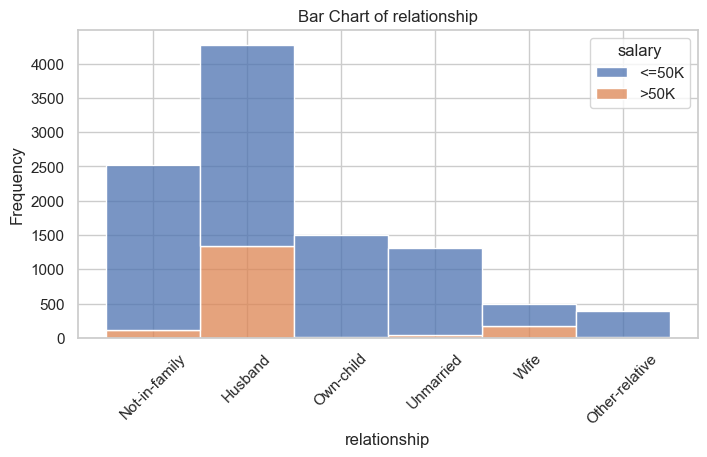

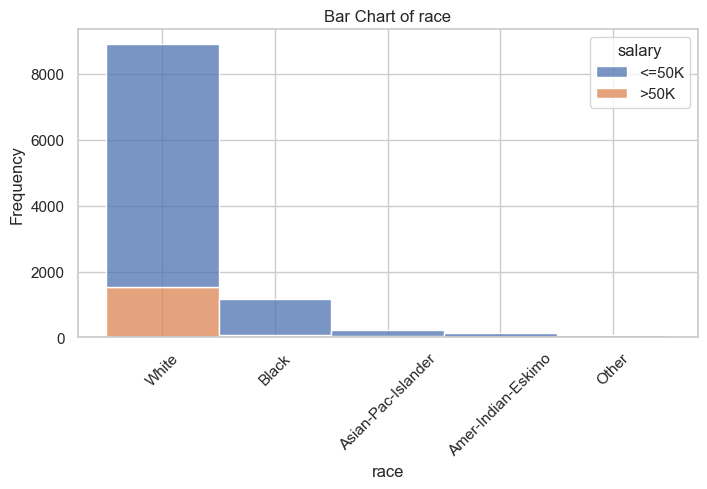

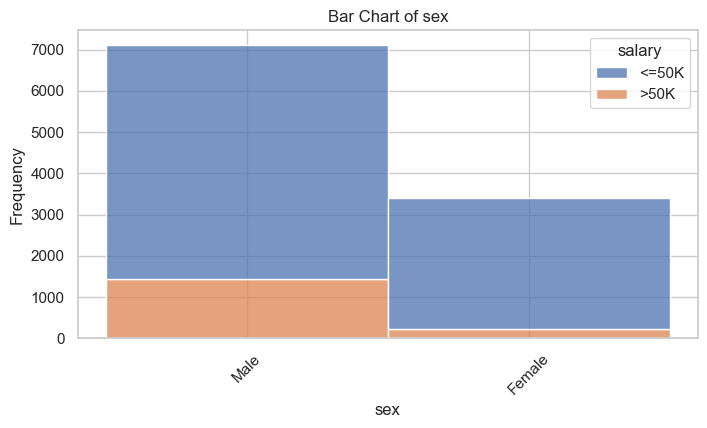

In [11]:
filtered_hs_grad_nvr_married = filtered_hs_grad[filtered_hs_grad["marital-status"] == "Never-married"]
filtered_hs_grad_nvr_married_private_job = filtered_hs_grad_nvr_married[filtered_hs_grad_nvr_married["workclass"] == "Private"]

print(filtered_hs_grad.shape)

for column in customer_df.select_dtypes(include='object').columns:
    if column in ["marital-status", "workclass", "education", "native-country","salary"]:
        continue
    plot_column_filter_by_class(filtered_hs_grad, column)


(<Figure size 640x480 with 3 Axes>,
 {('currently-unmarried', '<=50K'): (0.0,
   0.0,
   0.5238999560106168,
   0.9324378374775014),
  ('currently-unmarried', '>50K'): (0.0,
   0.935760096613714,
   0.5238999560106168,
   0.0642399033862859),
  ('currently-married', '<=50K'): (0.5288750803887262,
   0.0,
   0.47112491961127384,
   0.5612090204604357),
  ('currently-married', '>50K'): (0.5288750803887262,
   0.5645312795966484,
   0.47112491961127384,
   0.43546872040335155)})

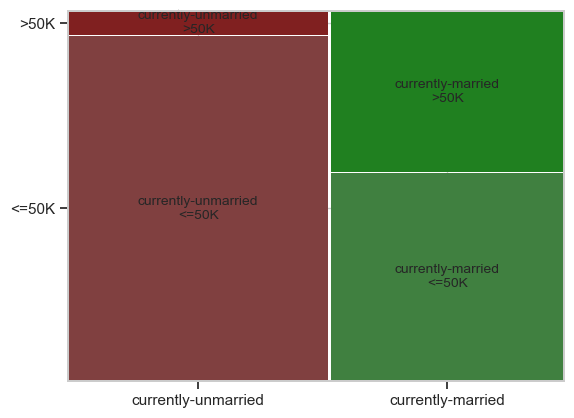

In [12]:
categorical_attributes = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex",
                          "native-country"]  # These attributes are categorical data

# Create a mosaic plot associating marital status to earning less than or greater than 50K
currently_married = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent']
customer_df["marital-status"] = customer_df["marital-status"].apply(
    lambda x: "currently-married" if x in currently_married else "currently-unmarried")
mosaic(customer_df, ["marital-status", "salary"])


In [13]:
onehot_encoder = OneHotEncoder(sparse=False, drop='first') 
onehot_encoded = onehot_encoder.fit_transform(customer_df)
#print(onehot_encoded[0])
dataset = customer_df.values[:,:-1]
label = customer_df.values[:,-1]
xyz = onehot_encoder.fit_transform(label)
print(xyz[0])


C:\Users\bistp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\bistp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=['<=50K' '<=50K' '<=50K' ... '<=50K' '<=50K' '>50K'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(dataset, label)
tree.plot_tree(model)
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(clf, 
#                   feature_names=iris.feature_names,  
#                   class_names=iris.target_names,
#                   filled=True)